# Fashion Image Classification with CNN

In [1]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

1. Importing Libraries

In [2]:
import numpy as np #for numerical computations
import pandas as pd #for dataframe operations

from matplotlib import pyplot as plt #for viewing images and plots
%matplotlib inline 
#So that Matplotlib plots don't open in separate windows outside the notebook

import urllib #For fetching data from Web URLs

import cv2   #For image processing

from sklearn.preprocessing import LabelEncoder    #For encoding categorical variables
from sklearn.model_selection import train_test_split #For splitting of dataset

#All tensorflow utilities for creating, training and working with a CNN
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [5]:
#Import the dataset

df = pd.read_csv('dress.csv')

Read Image from URL and view it using Pyplot

In [7]:



def show_image_from_url(image_url):

  """
  Fetches image online from the image_url and plots it as it is using matplotlib's pyplot's image show
  """

  response = urllib.request.urlopen(image_url)
  image = np.asarray(bytearray(response.read()), dtype="uint8")
  image_bgr = cv2.imdecode(image, cv2.IMREAD_COLOR)
  image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
  plt.imshow(image_rgb), plt.axis('off')

<Figure size 432x288 with 0 Axes>

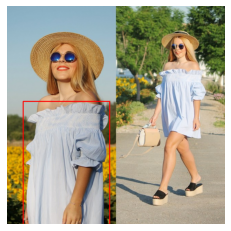

In [9]:
plt.figure()
show_image_from_url(df['image_url'].loc[9565])

In [10]:
print('All categories : \n ', df['category'].unique())

All categories : 
  ['ikat' 'plain' 'polka dot' 'geometry' 'floral' 'squares' 'scales'
 'animal' 'OTHER' 'stripes' 'tribal' 'houndstooth' 'cartoon' 'chevron'
 'stars' 'letter_numb' 'skull']


Remove the category 'OTHER' for adding simplicity.

In [11]:
n_classes = df['category'].nunique()
print('Total number of unique categories:', n_classes)

Total number of unique categories: 17


In [12]:
#Remove the category 'OTHER' from the dataset

df = df.loc[(df['category'] != 'OTHER')].reset_index(drop=True)

## Processing the Images

In [13]:
def image_processing(image_url):

  """
  Converts the URL of any image to an array of size 100x1 
  The array represents an OpenCV grayscale version of the original image
  The image will get cropped along the biggest red contour (4 line polygon) tagged on the original image (if any)
  """

  #Download from image url and import it as a numpy array
  response = urllib.request.urlopen(image_url)
  image = np.asarray(bytearray(response.read()), dtype="uint8")                         

  #Read the numpy arrays as color images in OpenCV
  image_bgr = cv2.imdecode(image, cv2.IMREAD_COLOR)

  #Convert to HSV for creating a mask
  image_hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)

  #Convert to grayscale that will actually be used for training, instead of color image 
  image_gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)

  #Create a mask that detects the red rectangular tags present in each image
  mask = cv2.inRange(image_hsv, (0,255,255), (0,255,255))

  #Get the coordinates of the red rectangle in the image, 
  #But take entire image if mask fails to detect the red rectangle
  if len(np.where(mask != 0)[0]) != 0:
    y1 = min(np.where(mask != 0)[0])
    y2 = max(np.where(mask != 0)[0])
  else:
    y1 = 0                                     
    y2 = len(mask)
  
  if len(np.where(mask != 0)[1]) != 0:
    x1 = min(np.where(mask != 0)[1])
    x2 = max(np.where(mask != 0)[1])
  else:
    x1 = 0
    x2 = len(mask[0])

  #Crop the grayscle image along those coordinates
  image_cropped = image_gray[y1:y2, x1:x2]

  #Resize the image to 100x100 pixels size
  image_100x100 = cv2.resize(image_cropped, (100, 100))

  #Save image as in form of array of 10000x1
  image_arr = image_100x100.flatten()
  return image_arr

### Downloading large data files directly from Google Drive

In [14]:
pip install gdown

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-3.13.0-py3-none-any.whl size=9034 sha256=82ed21a61fad8ba56393f834ffff032889371b06cd7507a24a13d9362f424794
  Stored in directory: /Users/qibili/Library/Caches/pip/wheels/04/51/53/ed3e97af28b242e9eb81afb4836273fbe233a14228aa82fea3
Successfully built gdown
Note: you may need to restart the kernel to use updated packages.


In [15]:
"""import gdown

url = 'https://drive.google.com/uc?id=1B6_rtcmGRy49hqpwoJT-_Ujnt6cYj5Ba'
output = 'X.npy'
gdown.download(url, output, quiet=False)

"""

Downloading...
From: https://drive.google.com/uc?id=1B6_rtcmGRy49hqpwoJT-_Ujnt6cYj5Ba
To: /Users/qibili/Documents/GitHub/Freelance_Projects/X.npy
1.22GB [1:22:27, 246kB/s]


'X.npy'

In [17]:
X = np.load('X.npy')
X[0:3]
X.shape

array([[0.29803922, 0.29803922, 0.29803922, ..., 0.60392157, 0.6       ,
        0.29803922],
       [0.4627451 , 0.29803922, 0.29803922, ..., 0.29803922, 0.29803922,
        0.29803922],
       [0.30196078, 0.29803922, 0.29803922, ..., 0.29803922, 0.29803922,
        0.29803922]])

(15189, 10000)

<Figure size 432x288 with 0 Axes>

(<matplotlib.image.AxesImage at 0x7fc5b3bc8790>, (-0.5, 99.5, 99.5, -0.5))

<Figure size 432x288 with 0 Axes>

(<matplotlib.image.AxesImage at 0x7fc5b3eb9d60>, (-0.5, 99.5, 99.5, -0.5))

<Figure size 432x288 with 0 Axes>

(<matplotlib.image.AxesImage at 0x7fc5abb06970>, (-0.5, 99.5, 99.5, -0.5))

<Figure size 432x288 with 0 Axes>

(<matplotlib.image.AxesImage at 0x7fc5abb3f970>, (-0.5, 99.5, 99.5, -0.5))

<Figure size 432x288 with 0 Axes>

(<matplotlib.image.AxesImage at 0x7fc5abb64b20>, (-0.5, 99.5, 99.5, -0.5))

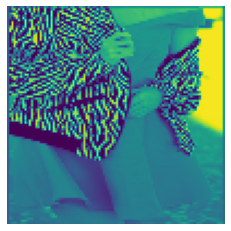

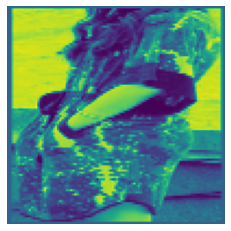

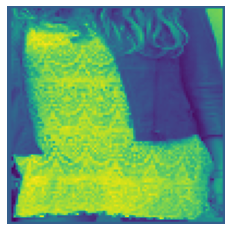

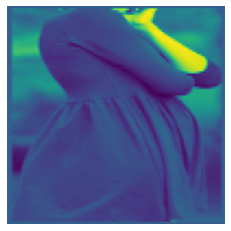

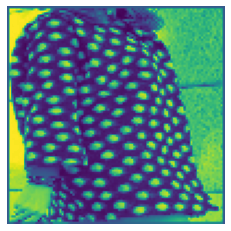

In [18]:
#Select 5 processed images at random from 'X' and plot 

np.random.seed(17)
for i in np.random.randint(0, len(X), 5):
  plt.figure()
  plt.imshow(X[i].reshape(100, 100)), plt.axis('off')

# Splitting the data
+ Creating the Target Array 

In [19]:
#Fetch the categories column from the dataframe, and tranform into to numerical labels

encoder = LabelEncoder()
Targets = encoder.fit_transform(df['category'])
Targets
Targets.shape

array([ 6,  8,  9, ..., 12, 15,  9])

(15189,)

In [20]:
#One-hot encoding of the Target vector

Y = to_categorical(Targets, num_classes = n_classes)
Y[0:3]
Y.shape

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0.]], dtype=float32)

(15189, 17)

Separation of a validation set, and a test set

In [21]:
#Segregation of a test set for testing on the trained model

X_test = X[14000:,]
Y_test = Y[14000:,]

#Seperation of a validation set from the remaing training set (required for validation while training)

X_train, X_val, Y_train, Y_val = train_test_split(X[:14000,], Y[:14000,], test_size=0.15, random_state=13)

Reshaping the input data

In [22]:
#Reshape the input matrices such that each sample is three-dimensional

img_rows, img_cols = 100, 100
input_shape = (img_rows, img_cols, 1)

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)

X_val.shape

(2100, 100, 100, 1)

### Convolutional Neural Network
+ Compiling the model

In [23]:
#Define a Convolutional Neural Network Model

model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu',
                 input_shape = input_shape))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(n_classes, activation='softmax'))

learning_rate = 0.001

model.compile(loss = categorical_crossentropy,
              optimizer = Adam(learning_rate),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 16)        160       
_________________________________________________________________
batch_normalization (BatchNo (None, 98, 98, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 16)        2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 32)        4

Saving the best weights

In [25]:
#Save the model during training 

save_at = "model.hdf5"
save_best = ModelCheckpoint (save_at, monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='max')

#### Training the CNN

Epoch 1/15
119/119 [==============================] - 115s 955ms/step - loss: 3.3470 - accuracy: 0.5260 - val_loss: 2.6170 - val_accuracy: 0.1781
Epoch 2/15
119/119 [==============================] - 104s 877ms/step - loss: 1.3854 - accuracy: 0.6446 - val_loss: 1.8019 - val_accuracy: 0.5176
Epoch 3/15
119/119 [==============================] - 108s 910ms/step - loss: 1.2862 - accuracy: 0.6661 - val_loss: 1.6653 - val_accuracy: 0.5824
Epoch 4/15
119/119 [==============================] - 118s 988ms/step - loss: 1.2472 - accuracy: 0.6784 - val_loss: 1.4092 - val_accuracy: 0.6386
Epoch 5/15
119/119 [==============================] - 118s 993ms/step - loss: 1.2283 - accuracy: 0.6799 - val_loss: 1.3774 - val_accuracy: 0.6490
Epoch 6/15
119/119 [==============================] - 118s 995ms/step - loss: 1.1640 - accuracy: 0.7024 - val_loss: 1.2250 - val_accuracy: 0.6895
Epoch 7/15
119/119 [==============================] - 107s 900ms/step - loss: 1.1414 - accuracy: 0.7025 - val_loss: 1.3909 -

<Figure size 432x360 with 0 Axes>

Text(0.5, 1.0, 'Model Accuracy')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'epoch')

(0.4, 0.9)

(array([-2.,  0.,  2.,  4.,  6.,  8., 10., 12., 14., 16.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

(array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

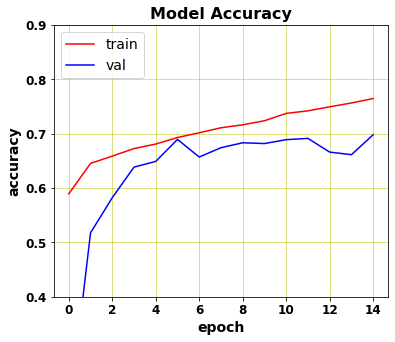

In [26]:
#Train the CNN

history = model.fit( X_train, Y_train, 
                    epochs = 15, batch_size = 100, 
                    callbacks=[save_best], verbose=1, 
                    validation_data = (X_val, Y_val))

# Plot the training history (Training accuracy & Validation accuracy)

plt.figure(figsize=(6, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy', weight='bold', fontsize=16)
plt.ylabel('accuracy', weight='bold', fontsize=14)
plt.xlabel('epoch', weight='bold', fontsize=14)
plt.ylim(0.4, 0.9)
plt.xticks(weight='bold', fontsize=12)
plt.yticks(weight='bold', fontsize=12)
plt.legend(['train', 'val'], loc='upper left', prop={'size': 14})
plt.grid(color = 'y', linewidth='0.5')
plt.show()

### Evaluating Performace with Test-Set

In [27]:
#Run model on the held-out test set

model = load_model('model.hdf5')
score = model.evaluate(X_test, Y_test, verbose=0)
print('Accuracy over the test set: \n ', round((score[1]*100), 2), '%')

Accuracy over the test set: 
  70.23 %


<Figure size 432x288 with 0 Axes>

(<matplotlib.image.AxesImage at 0x7fc4b36522e0>, (-0.5, 99.5, 99.5, -0.5))

Text(0.5, 1.0, 'animal')

<Figure size 432x288 with 0 Axes>

(<matplotlib.image.AxesImage at 0x7fc4b367bf70>, (-0.5, 99.5, 99.5, -0.5))

Text(0.5, 1.0, 'animal')

<Figure size 432x288 with 0 Axes>

(<matplotlib.image.AxesImage at 0x7fc4b3d486a0>, (-0.5, 99.5, 99.5, -0.5))

Text(0.5, 1.0, 'plain')

<Figure size 432x288 with 0 Axes>

(<matplotlib.image.AxesImage at 0x7fc4b3f04850>, (-0.5, 99.5, 99.5, -0.5))

Text(0.5, 1.0, 'animal')

<Figure size 432x288 with 0 Axes>

(<matplotlib.image.AxesImage at 0x7fc4b3f3e580>, (-0.5, 99.5, 99.5, -0.5))

Text(0.5, 1.0, 'stripes')

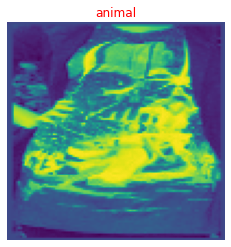

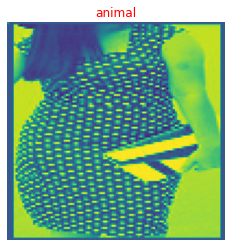

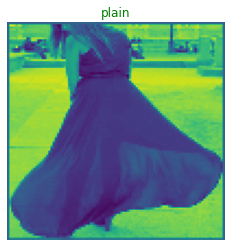

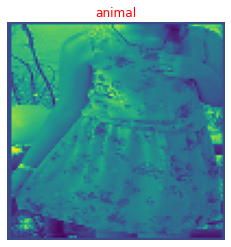

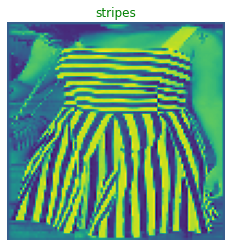

In [28]:
Y_pred = np.round(model.predict(X_test))

np.random.seed(87)
for rand_num in np.random.randint(0, len(Y_test), 5):
  plt.figure()
  plt.imshow(X_test[rand_num].reshape(100, 100)), plt.axis('off')
  if np.where(Y_pred[rand_num] == 1)[0].sum() == np.where(Y_test[rand_num] == 1)[0].sum():
    plt.title(encoder.classes_[np.where(Y_pred[rand_num] == 1)[0].sum()], color='g')
  else :
    plt.title(encoder.classes_[np.where(Y_pred[rand_num] == 1)[0].sum()], color='r')

### Finding similar Images

In [29]:
def find_similar_images(image_url, no_of_images):

  """
  Takes in an image_url, and number of similar images needed.
  Model makes prediction on the dress category in the image
  The original image and desired number of similar images from the dataset are plotted
  """

  X_query = image_processing(image_url)
  X_query = X_query/255
  X_query = X_query.reshape(1, 100, 100, 1)
  Y_query = np.round(model.predict(X_query))
  i = np.where(Y_query == 1)[0].sum()
  print('Type detected by model:', encoder.classes_[i].upper())
  df_req = df.loc[ df['category'] == encoder.classes_[i]]
  df_req = df_req.reset_index(drop=True)

  if no_of_images > len(df_req):
    return(print('number of images needed are more than similar images in the dataset'))

  plt.figure()
  show_image_from_url(image_url)
  plt.title('Query Image')

  c = 1
  np.random.seed(13)
  for j in np.random.randint(0, len(df_req), no_of_images):
    plt.figure()
    url = df_req['image_url'].iloc[j]
    show_image_from_url(url)
    plt.title('Similar Image {}'.format(c))
    c += 1

Type detected by model: ANIMAL


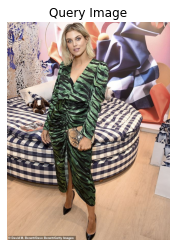

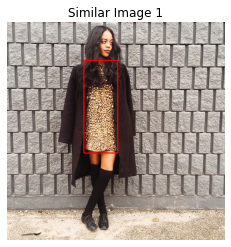

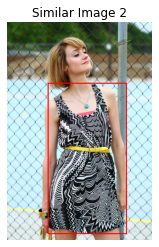

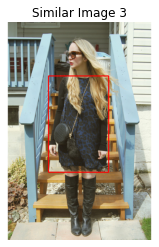

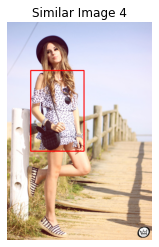

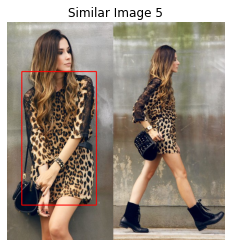

In [30]:
find_similar_images('https://i.dailymail.co.uk/1s/2018/11/06/23/5855600-6360713-Ashley_James_stuns_in_emerald_green_animal_print_dress_at_glitzy-a-123_1541546195058.jpg', 5)